In [1]:
# Importing everything for Time Series
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

sns.set()

import warnings  
warnings.filterwarnings("ignore") 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [2]:
df = pd.read_csv("orders.csv")
df

,created_at_utc,tariff_class,tariff_internal_name,status,taxi_status,vehicle_model,vehicle_color,vehicle_car_region,payment_cost,payment_currency_code,driver_call_model
0,1622145491,Эконом,econom,cancelled,waiting,Kia Rio,белый,34,52.00,RUB,no_call
1,1622145422,Эконом,econom,cancelled,driving,LADA (ВАЗ) Granta,серый,34,0.00,RUB,no_call
2,1622145212,Эконом,econom,finished,complete,Renault Logan,белый,34,104.70,RUB,on_demand
3,1622054615,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,белый,34,120.00,RUB,on_demand
4,1622045036,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,белый,34,115.50,RUB,on_demand
...,...,...,...,...,...,...,...,...,...,...,...
1200,1617028952,Эконом,econom,finished,complete,LADA (ВАЗ) Largus,белый,34,472.40,RUB,no_call
1201,1617028458,Эконом,econom,cancelled,driving,LADA (ВАЗ) Granta,белый,34,0.00,RUB,no_call
1202,1617025078,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,серый,34,146.85,RUB,no_call
1203,1616869125,Эконом,econom,cancelled,driving,LADA (ВАЗ) Largus,серый,34,0.00,RUB,no_call


In [3]:
df = pd.read_csv("orders.csv")
df = df.loc[df['payment_cost']!=0]
df = df.loc[df['tariff_internal_name']=='econom']
df = df.dropna()

In [4]:
#Converting to date-time
df = df[['created_at_utc','payment_cost']]
df['created_at_utc'] = pd.to_datetime(df.created_at_utc,unit='s')
df['created_at_utc'] = pd.to_datetime(df.created_at_utc,unit=None)
df.sort_values(by=['created_at_utc'], inplace=True)
df = df.loc[df['payment_cost']!=0]
df.set_index('created_at_utc', inplace=True)

In [6]:
df

,payment_cost
created_at_utc,
2017-09-30 20:36:04,58.65
2017-09-30 21:07:25,98.90
2017-10-18 06:24:17,438.15
2017-10-19 05:49:34,425.50
2017-10-27 13:27:24,89.70
...,...
2021-05-26 12:14:23,83.70
2021-05-26 16:03:56,115.50
2021-05-26 18:43:35,120.00


In [7]:
# Creating a copy of the initial datagrame to make various transformations
data = df.copy()
data.columns = ["y"]

In [8]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 11):
    data["lag_{}".format(i)] = data.y.shift(i)

In [9]:
data

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
created_at_utc,,,,,,,,,,,
2017-09-30 20:36:04,58.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-30 21:07:25,98.90,58.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-18 06:24:17,438.15,98.90,58.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-19 05:49:34,425.50,438.15,98.90,58.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-27 13:27:24,89.70,425.50,438.15,98.90,58.65,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-26 12:14:23,83.70,461.90,580.00,157.05,570.00,73.45,680.00,430.45,136.35,94.45,168.00
2021-05-26 16:03:56,115.50,83.70,461.90,580.00,157.05,570.00,73.45,680.00,430.45,136.35,94.45
2021-05-26 18:43:35,120.00,115.50,83.70,461.90,580.00,157.05,570.00,73.45,680.00,430.45,136.35


In [10]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [11]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [12]:
X

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
created_at_utc,,,,,,,,,,
2017-11-23 20:18:01,127.65,64.00,118.45,73.60,106.95,89.70,425.50,438.15,98.90,58.65
2017-12-01 12:10:14,139.15,127.65,64.00,118.45,73.60,106.95,89.70,425.50,438.15,98.90
2017-12-01 15:13:38,95.00,139.15,127.65,64.00,118.45,73.60,106.95,89.70,425.50,438.15
2017-12-04 12:17:36,37.00,95.00,139.15,127.65,64.00,118.45,73.60,106.95,89.70,425.50
2017-12-13 06:38:21,533.60,37.00,95.00,139.15,127.65,64.00,118.45,73.60,106.95,89.70
...,...,...,...,...,...,...,...,...,...,...
2021-05-26 12:14:23,461.90,580.00,157.05,570.00,73.45,680.00,430.45,136.35,94.45,168.00
2021-05-26 16:03:56,83.70,461.90,580.00,157.05,570.00,73.45,680.00,430.45,136.35,94.45
2021-05-26 18:43:35,115.50,83.70,461.90,580.00,157.05,570.00,73.45,680.00,430.45,136.35


**LinearRegression**

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
def plotModelResults(
    model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False
):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
        )
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed");

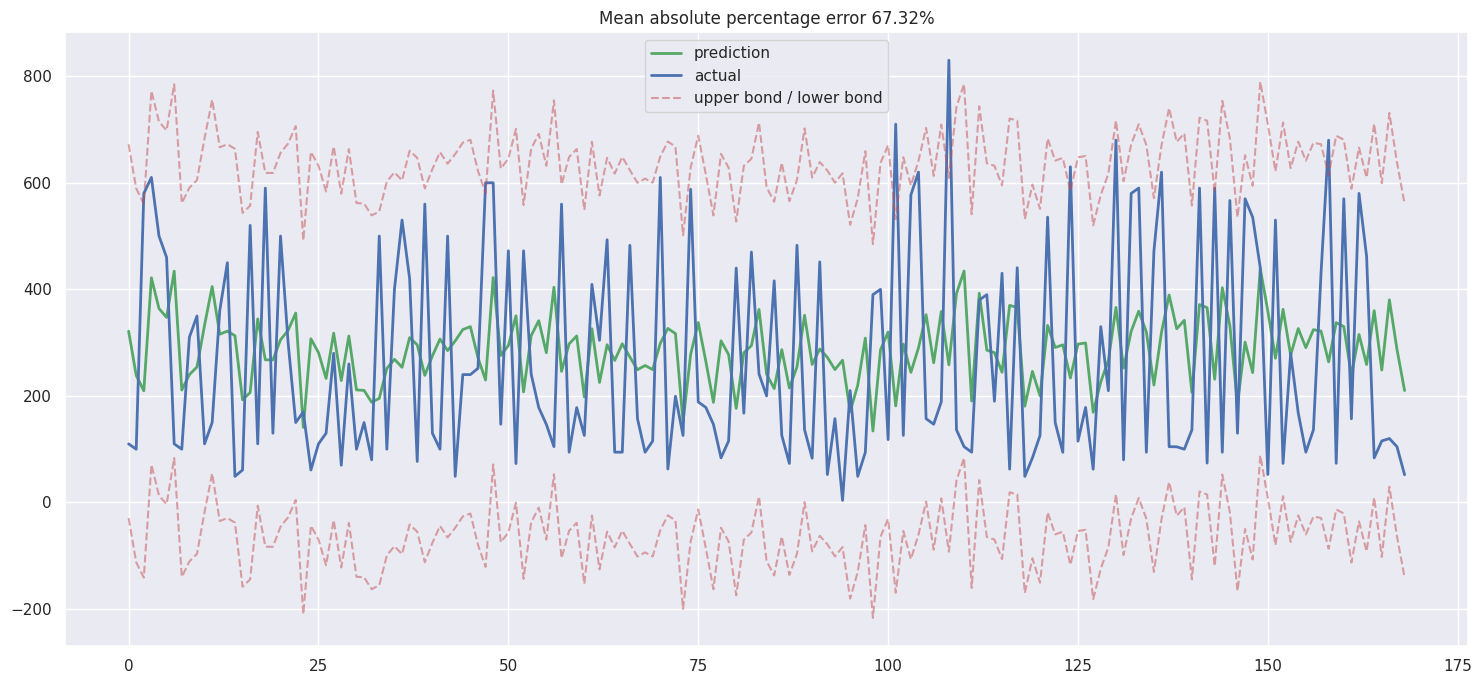

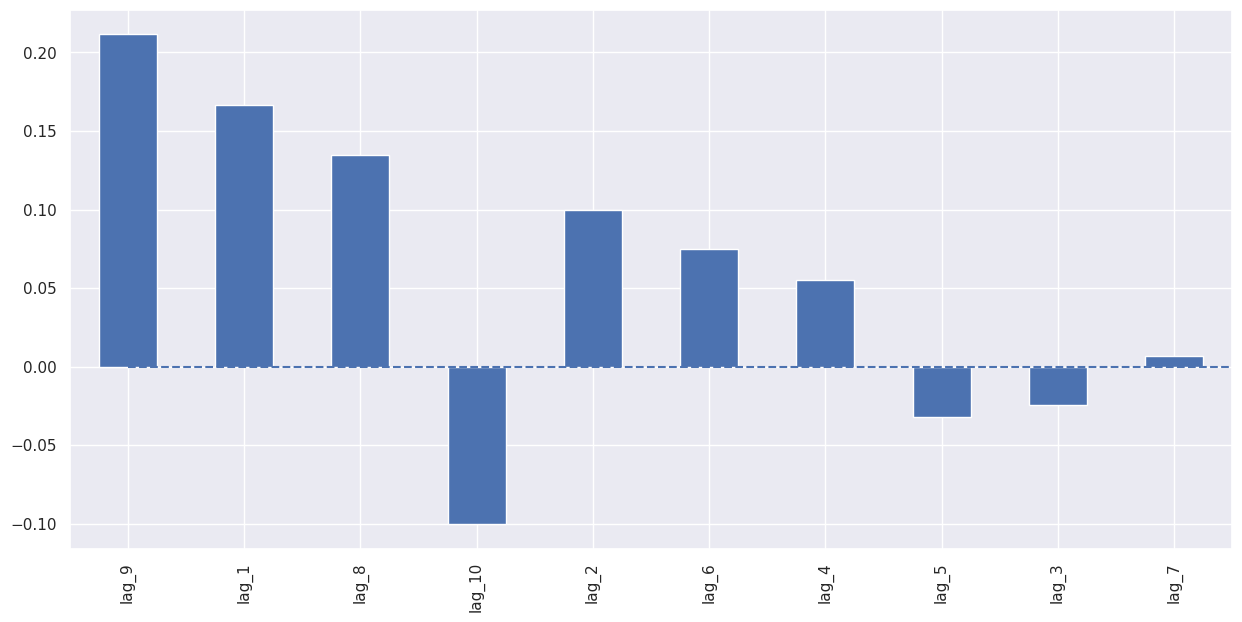

In [16]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [17]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data["is_weekend"] = data.weekday.isin([5, 6]) * 1
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,hour,weekday,is_weekend
created_at_utc,,,,,,,,,,,,,,
2021-05-26 12:14:23,83.7,461.9,580.0,157.05,570.00,73.45,680.00,430.45,136.35,94.45,168.00,12,2,0
2021-05-26 16:03:56,115.5,83.7,461.9,580.00,157.05,570.00,73.45,680.00,430.45,136.35,94.45,16,2,0
2021-05-26 18:43:35,120.0,115.5,83.7,461.90,580.00,157.05,570.00,73.45,680.00,430.45,136.35,18,2,0
2021-05-27 19:53:32,104.7,120.0,115.5,83.70,461.90,580.00,157.05,570.00,73.45,680.00,430.45,19,3,0
2021-05-27 19:58:11,52.0,104.7,120.0,115.50,83.70,461.90,580.00,157.05,570.00,73.45,680.00,19,3,0


**Scaled LinearRegression with StandardScaler**

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

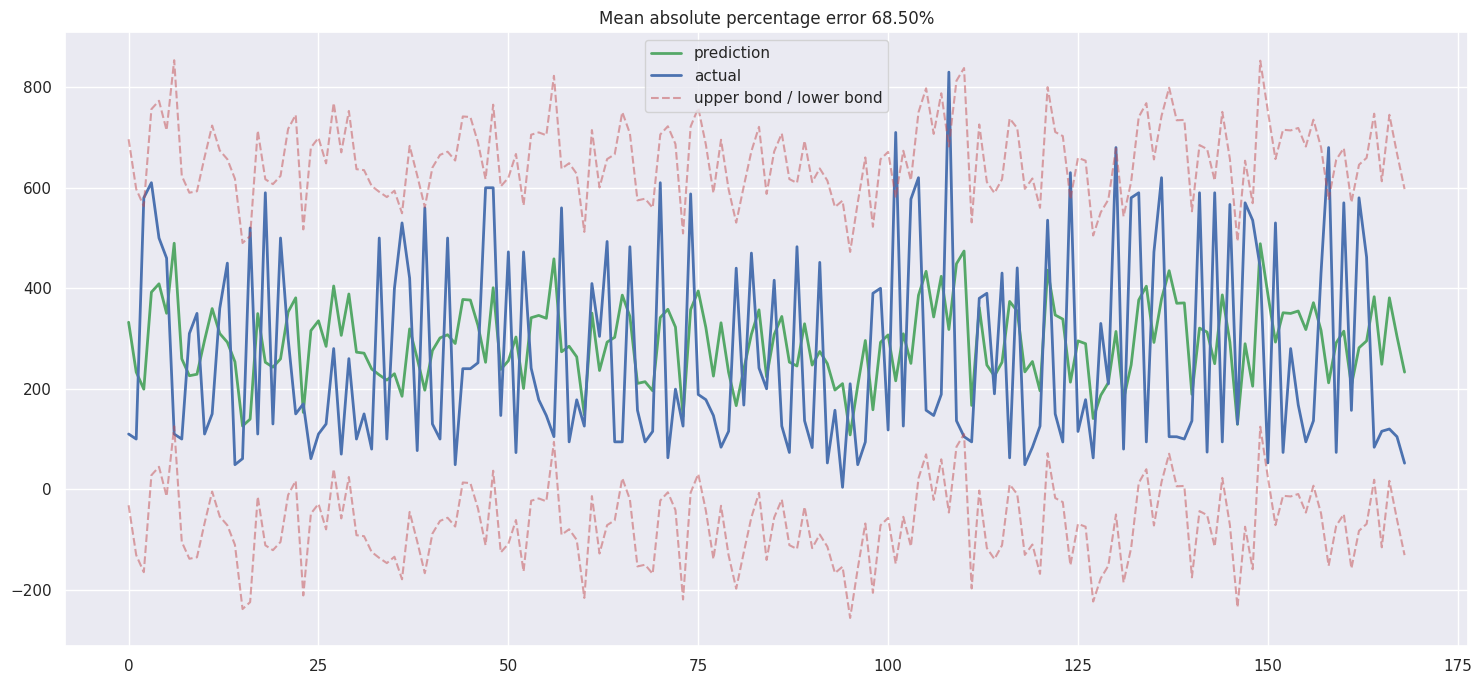

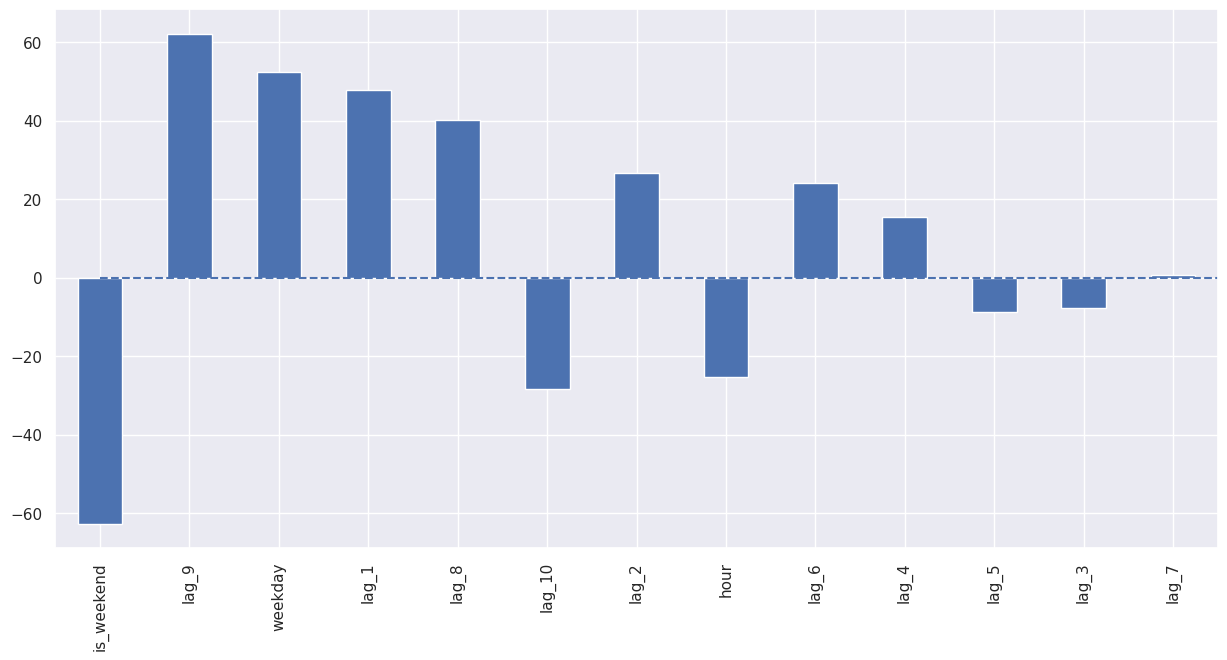

In [19]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

**LassoCV and RidgeCV**

In [20]:
from sklearn.linear_model import LassoCV, RidgeCV

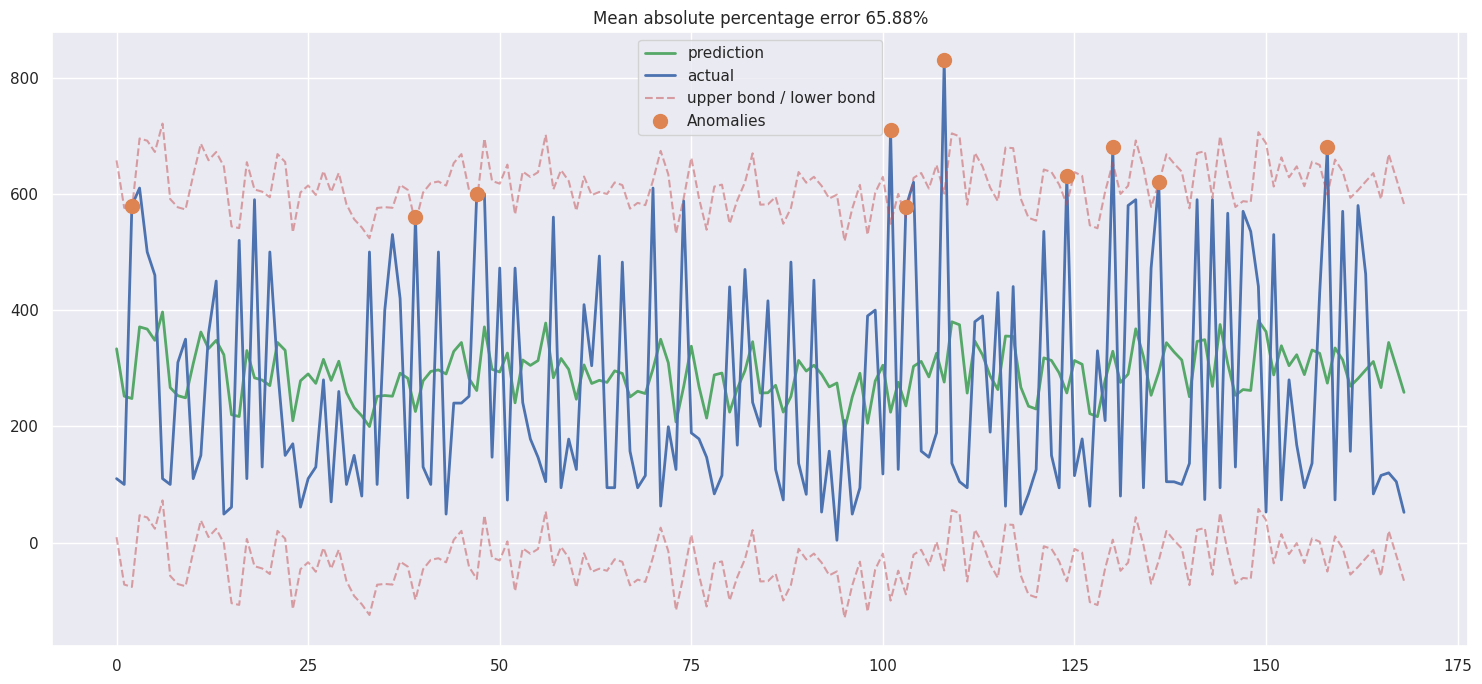

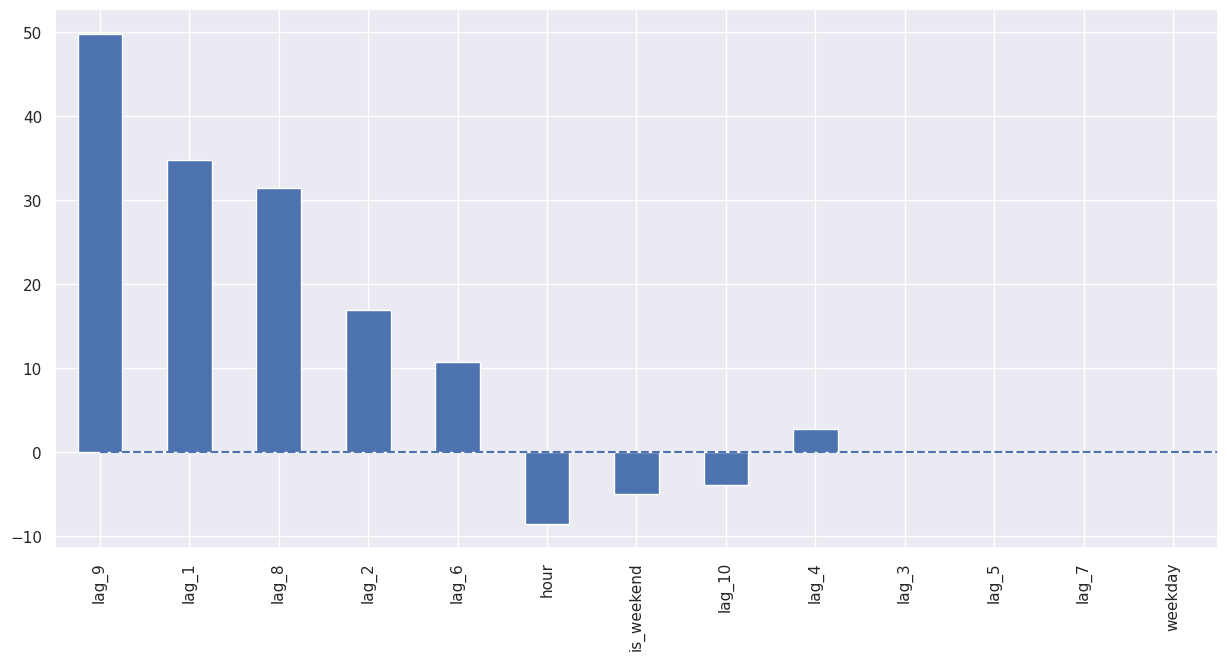

In [21]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(
    lasso,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    plot_intervals=True,
    plot_anomalies=True,
)
plotCoefficients(lasso)

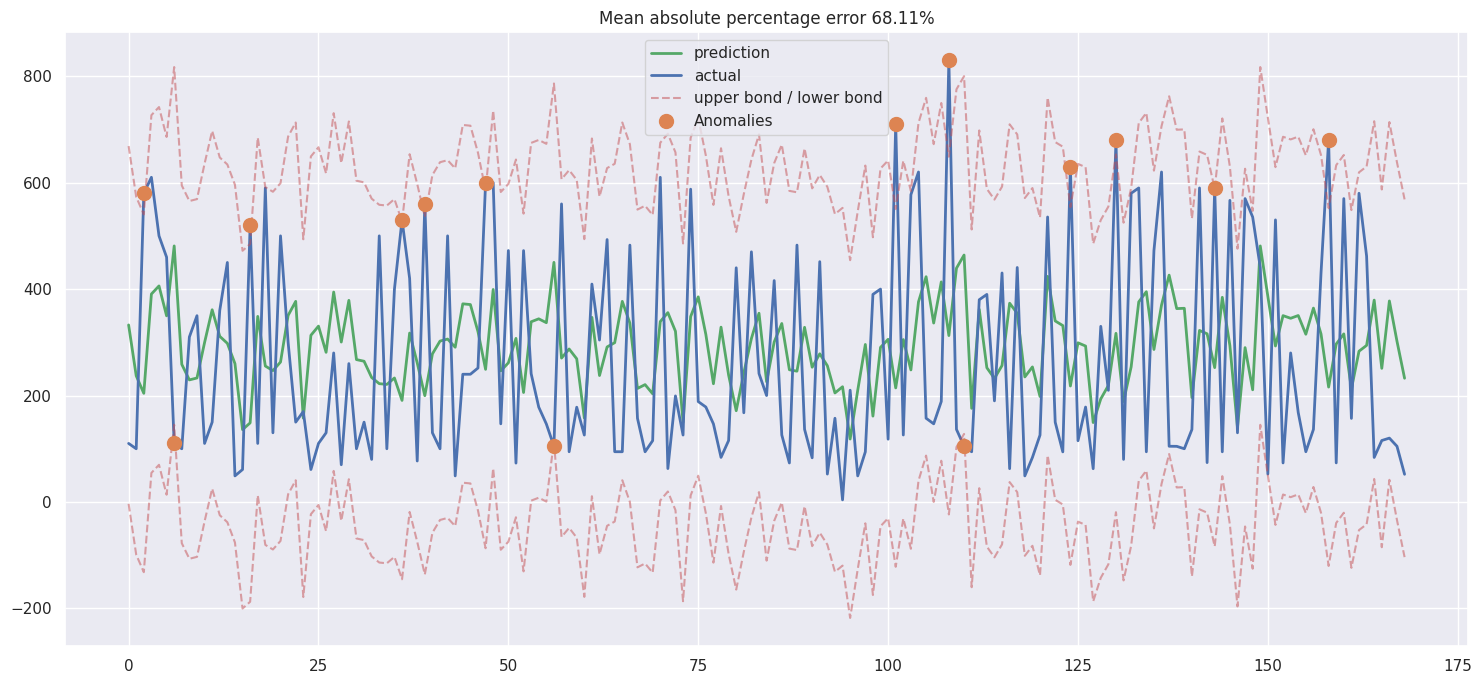

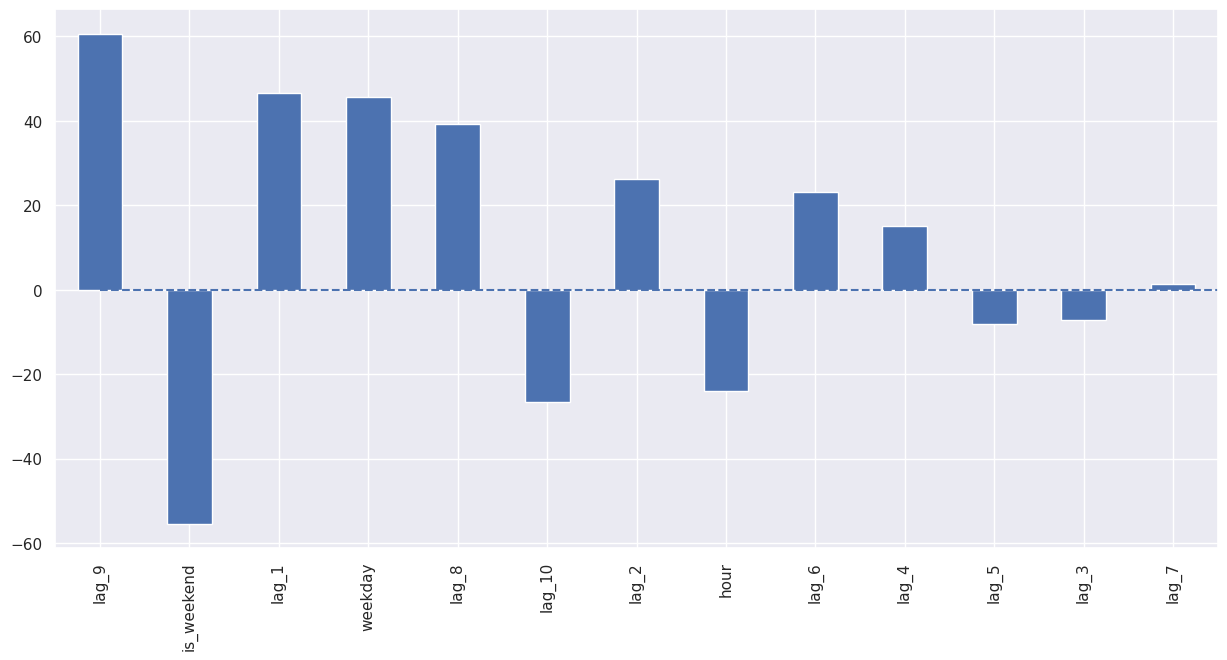

In [22]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(
    ridge,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    plot_intervals=True,
    plot_anomalies=True,
)
plotCoefficients(ridge)

**XGBRegressor and RandomForestRegressor**

In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor(verbosity=0)
xgb.fit(X_train_scaled, y_train);

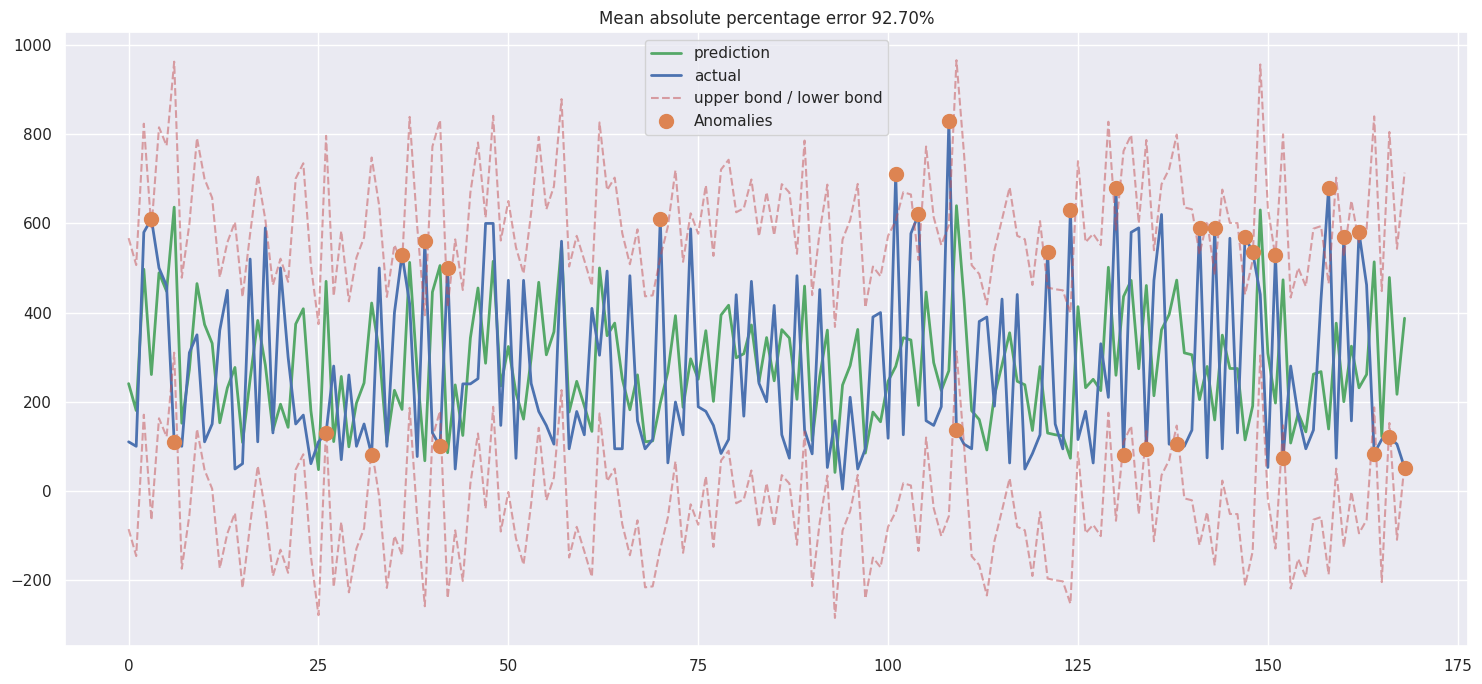

In [24]:
plotModelResults(
    xgb,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    plot_intervals=True,
    plot_anomalies=True,
)

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1, random_state=17)
rf.fit(X_train, y_train);

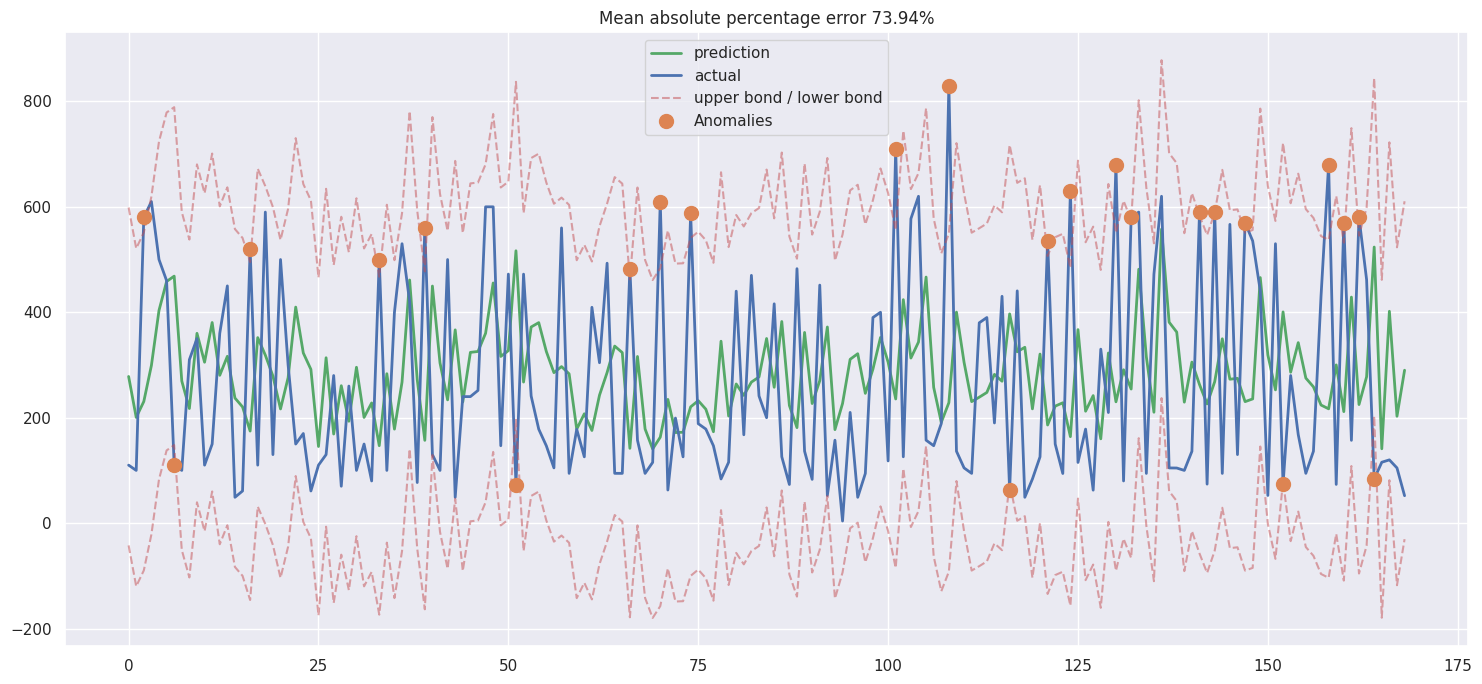

In [26]:
plotModelResults(
    rf,
    X_train=X_train,
    X_test=X_test,
    plot_intervals=True,
    plot_anomalies=True,
)